#### Before running this notebook, please make sure to run the `verification_vae_performance_compute.ipynb` notebook to generate the pickle files.

In [9]:
import sys
sys.path.append('..')
import os

import numpy as np
from pysteps.visualization.spectral import plot_spectrum1d
import matplotlib.pyplot as plt
import pickle
import matplotlib

In [10]:
def plot_sal(sal: np.ndarray, title: str = None):
    s_q1 = np.nanpercentile(sal[:,0], 25)
    s_q3 = np.nanpercentile(sal[:,0], 75)
    a_q1 = np.nanpercentile(sal[:,1], 25)
    a_q3 = np.nanpercentile(sal[:,1], 75)
    #average Structure, Amplitude and Location scores
    s, a, l = np.nanmean(np.abs(sal), axis=0)
    fig, ax = plt.subplots(dpi=150)
    ima = plt.scatter(sal[:,0], sal[:,1], c=sal[:,2], cmap='gnuplot_r', s=1, vmax=0.5)
    ax.add_patch(plt.Rectangle((s_q1, a_q1), s_q3-s_q1, a_q3-a_q1, fill=None, color='black', linestyle='-', lw=1))
    ax.vlines(0, -2, 2, color='gray', linestyle='-', lw=1)
    ax.hlines(0, -2, 2, color='gray', linestyle='-', lw=1)
    ax.vlines(np.nanmedian(sal[:,0]), -2, 2, color='black', linestyle='--')
    ax.hlines(np.nanmedian(sal[:,1]), -2, 2, color='black', linestyle='--')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xlabel('(S)tructure')
    plt.ylabel('(A)mplitude')
    plt.annotate('L', (-0.486, 0.444), fontsize=11, color='black', fontweight='bold')
    # add avergae values to the plot as text in the top right corner of the plot
    plt.text(0.99, 0.9, f'S: {s:.3f}\nA: {a:.3f}\nL: {l:.3f}\nS+A+L: {s+a+l:.3f}', horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
    cb = fig.colorbar(ima,  cax=ax.inset_axes((0.04, 0.94, 0.43, 0.04)), orientation='horizontal')
    plt.title(title)
    plt.show()

In [11]:
pickle_dir = '../data/verification_vae/'
old_vae = "vae_mae"
new_vae = "vae_mwae"

In [12]:
spec_old = pickle.load(open(os.path.join(pickle_dir, f'{old_vae}.spectra.pkl'), 'rb'))
spec_new = pickle.load(open(os.path.join(pickle_dir, f'{new_vae}.spectra.pkl'), 'rb'))

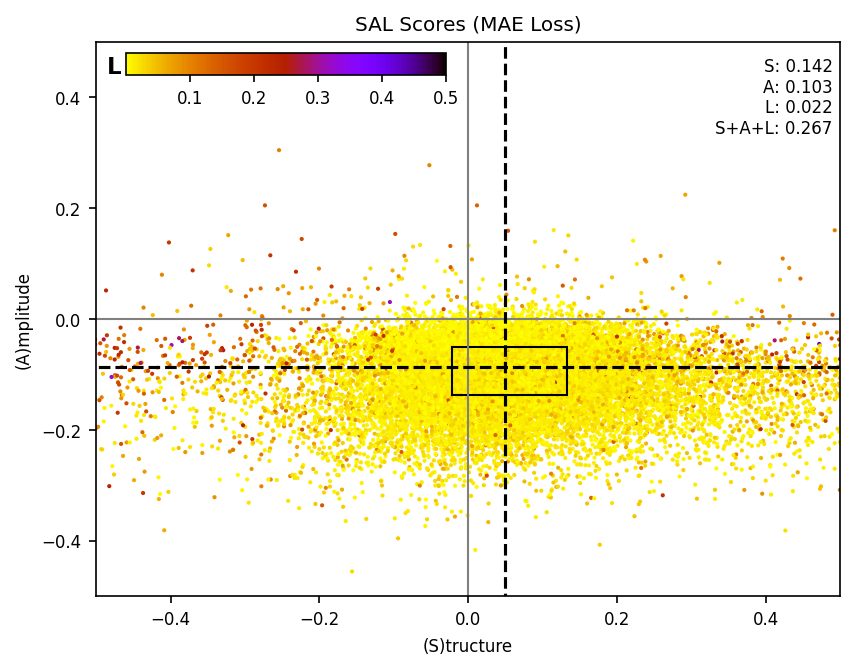

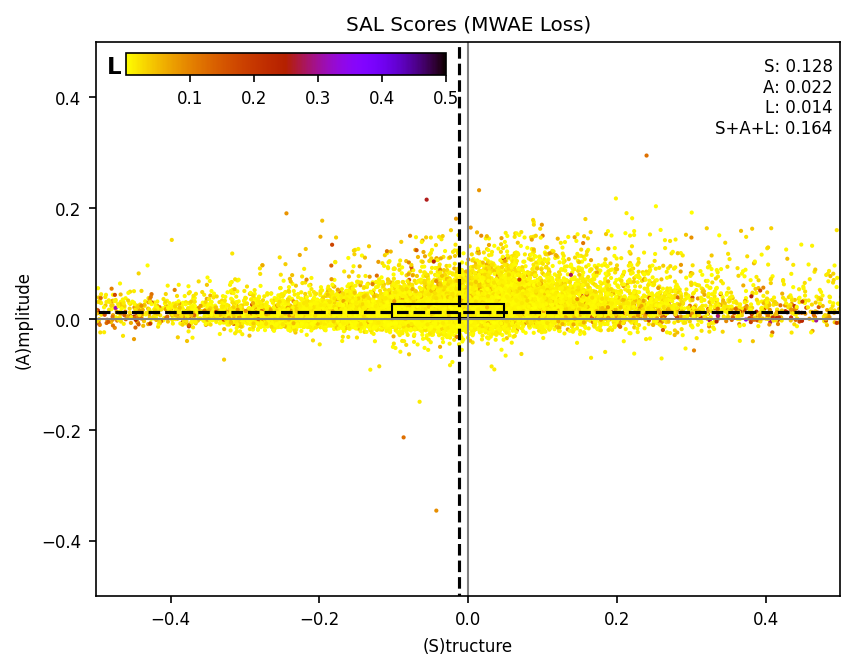

In [13]:
plot_sal(np.array(spec_old['sal']), 'SAL Scores (MAE Loss)')
plot_sal(np.array(spec_new['sal']), 'SAL Scores (MWAE Loss)')

In [14]:
# plot power spectras
spec_input = np.array(spec_old['input'])
spec_recons_old = np.array(spec_old['recons'])
spec_recons_new = np.array(spec_new['recons'])
spec_freq = spec_old['freq']

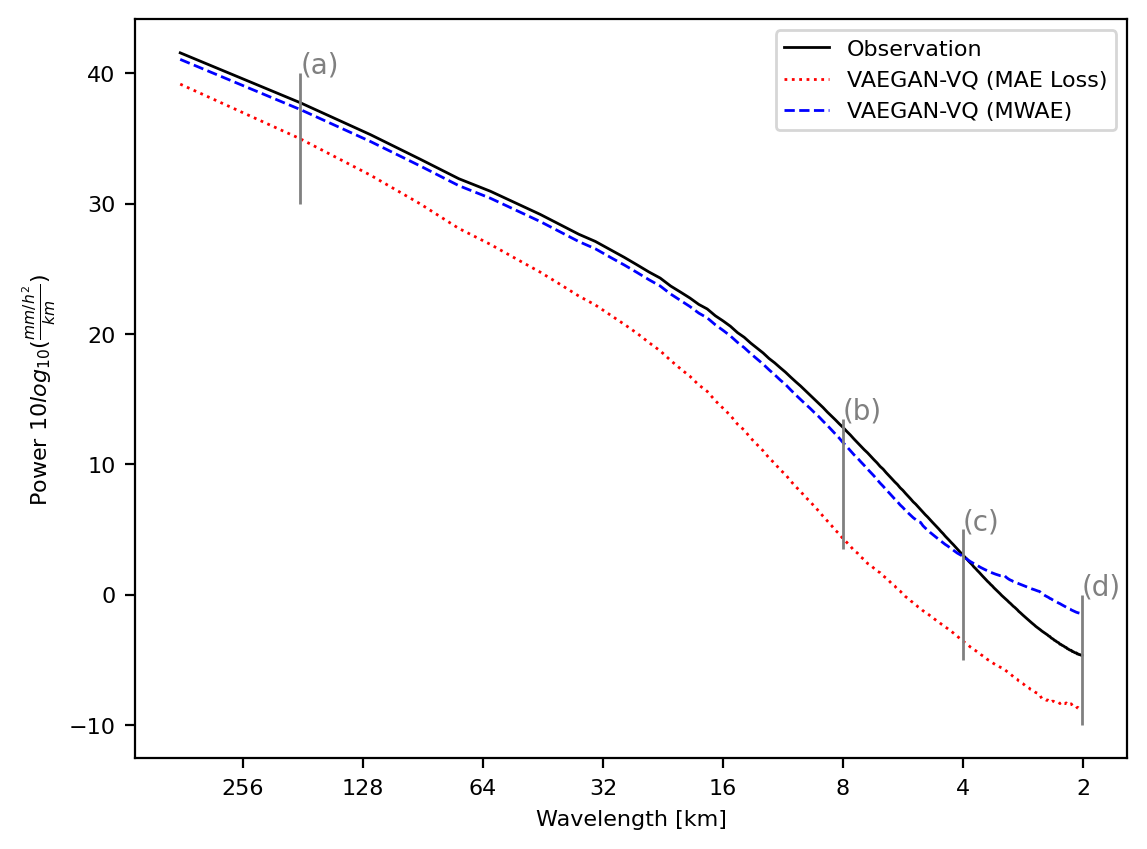

In [15]:
fig, ax = plt.subplots(1, 1, dpi=200)
wavelength_ticks = [256, 128, 64, 32, 16, 8, 4, 2]
# plot vertical segments at 184km, 8km, 4km and 2km
indexes = [2, 46, 92, -1]
plot_spectrum1d(spec_freq, spec_input.mean(axis=0), x_units='km', y_units='mm/h', color='k', lw=1, ax=ax, wavelength_ticks=wavelength_ticks, label='Observation')
plot_spectrum1d(spec_freq, spec_recons_old.mean(axis=0), x_units='km', y_units='mm/h', color='red', linestyle=':', ax=ax, wavelength_ticks=wavelength_ticks, label='VAEGAN-VQ (MAE Loss)')
plot_spectrum1d(spec_freq, spec_recons_new.mean(axis=0), x_units='km', y_units='mm/h', color='blue', linestyle='--', ax=ax, wavelength_ticks=wavelength_ticks, label='VAEGAN-VQ (MWAE)')

ax.vlines(10 * np.log10(spec_freq[2]), 30, 40, color='gray', linestyle='-', lw=1)
ax.annotate('(a)', (10 * np.log10(spec_freq[2]), 40), fontsize=10, color='gray')
ax.vlines(10 * np.log10(spec_freq[46]), 3.5, 13.5, color='gray', linestyle='-', lw=1)
ax.annotate('(b)', (10 * np.log10(spec_freq[46]), 13.5), fontsize=10, color='gray')
ax.vlines(10 * np.log10(spec_freq[92]), -5, 5, color='gray', linestyle='-', lw=1)
ax.annotate('(c)', (10 * np.log10(spec_freq[92]), 5), fontsize=10, color='gray')
ax.vlines(10 * np.log10(spec_freq[-1]), -10, 0, color='gray', linestyle='-', lw=1)
ax.annotate('(d)', (10 * np.log10(spec_freq[-1]), 0), fontsize=10, color='gray')
plt.legend()
plt.show()


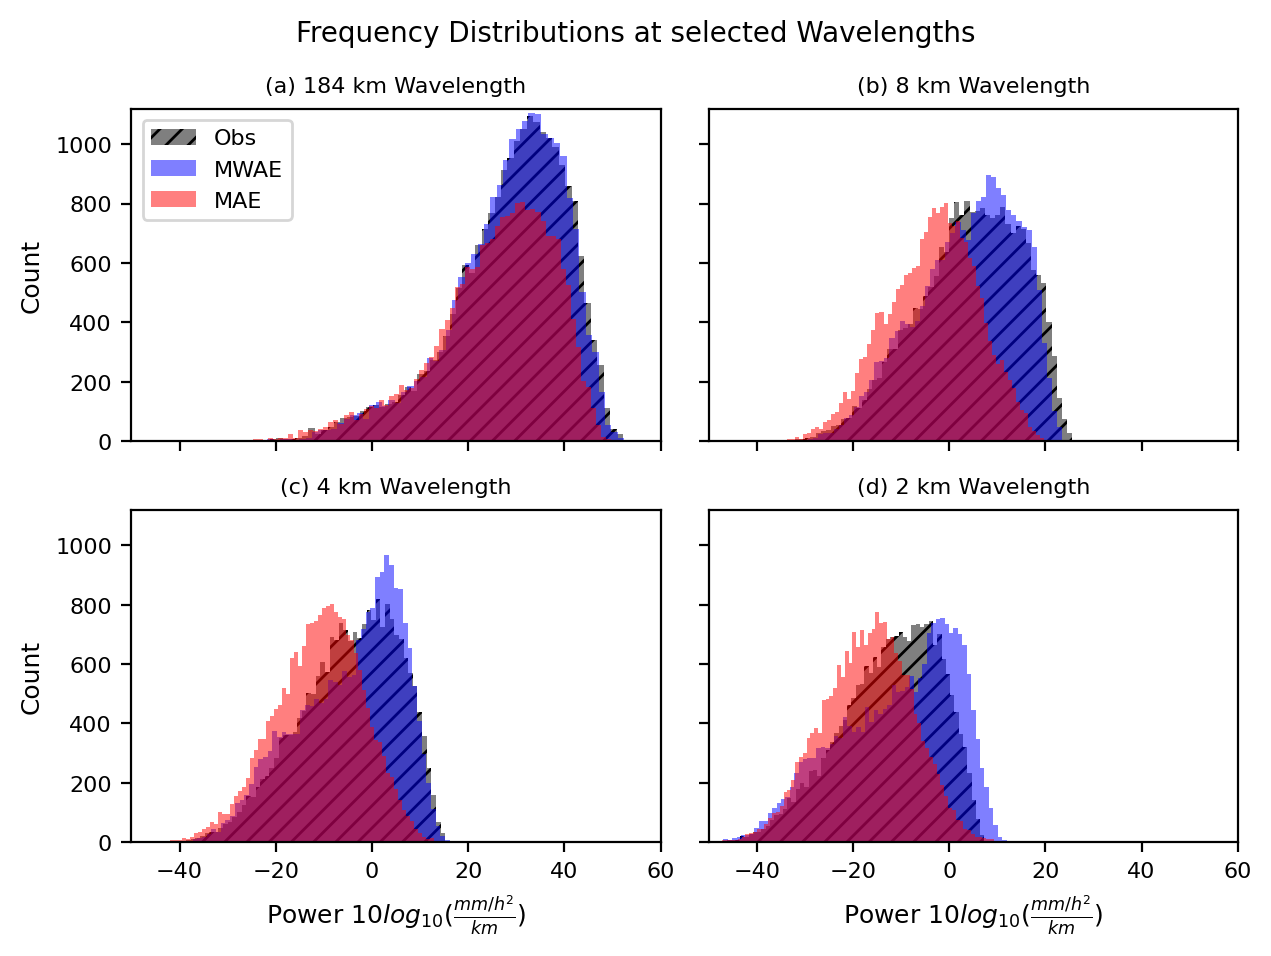

In [16]:
x_units = 'km'
y_units = 'mm/h'
matplotlib.rcParams.update({'font.size': 8})
power_units = rf"$10log_{{ 10 }}(\frac{{ {y_units}^2 }}{{ {x_units} }})$"
feq_idx = 2
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)
fig.suptitle('Frequency Distributions at selected Wavelengths', fontsize=10)
indexes = [2, 46, 92, -1]
for i in range(4):
    ax[i//2, i%2].hist(10*np.log10(spec_input[:, indexes[i]]+1e-8), bins=100, alpha=0.5, label='Obs', color='k', hatch='///' );
    ax[i//2, i%2].hist(10*np.log10(spec_recons_new[:, indexes[i]]+1e-8), bins=100, alpha=0.5, label='MWAE', color='blue');
    ax[i//2, i%2].hist(10*np.log10(spec_recons_old[:, indexes[i]]+1e-8), bins=100, alpha=0.5, label='MAE', color='red');
    if i//2 == 1:
        ax[i//2, i%2].set_xlabel(f"Power {power_units}", fontsize=9)
    if i%2 == 0:
        ax[i//2, i%2].set_ylabel("Count", fontsize=9)
    ax[i//2, i%2].set_title(f'({chr(97+i)}) {1/spec_freq[indexes[i]]:.0f} km Wavelength', fontsize=8)

ax[0,0].legend(fontsize=8)
plt.xlim(-50, 60)
plt.ylim(0, 1120)

fig.tight_layout()
plt.tight_layout()
